# Computational Challenge 2
*Model 1:* Quasi-stationary distributions in the birth-death model.


*Group 2:* Daniel, Thuyen, Danial, and Manoj.

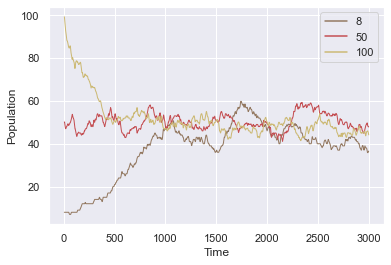

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from numba import jit
import seaborn as sns
sns.set()


# sns.set(style="whitegrid")


# Function: Change of Population
@jit(nopython=True)
def changePop(b, d):
    r = np.random.random_sample()
    if r < b:
        return 1
    elif r > (b+d):
        return 0
    else:
        return -1


# Function: Find Probability of Birth/Dearth/None
@jit(nopython=True)
def findProp(i):
    b = r*(i - np.power(i, 2)/N)
    d = r*np.power(i, 2)/N
    return b, d


# Function: Generate One Population Trajectory
@jit(nopython=True)
def popTrajectory(t, P0):
    pop = np.zeros(t)
    pop[0] = P0
    for k in range(t-1):
        if pop[k] < 1:
            break
        else:
            b, d = findProp(pop[k])
            pop[k+1] = pop[k] + changePop(b, d)
    return pop


# Generate and plot some population trajectories
# --- Intial Parameters
r = 0.004
K = 50
t = 3000
aP0 = [8, 50, 100]  # Initial population

N = 2*K


#--- Plot
current_palette = sns.color_palette()
for P0 in aP0:
    pop = popTrajectory(t, P0)
    tm = np.linspace(0, t-1, t)
    time_pop = pd.DataFrame(pop, tm, [P0])
    time_pop = time_pop.rolling(7).mean()
    ax = sns.lineplot(data=time_pop, palette=[current_palette[np.random.randint(0,len(current_palette))]], linewidth=1)

ax.set(xlabel='Time', ylabel='Population')
plt.show()

fig = ax.get_figure()
fig.savefig("1-1-PopulationTrajectories.png") 

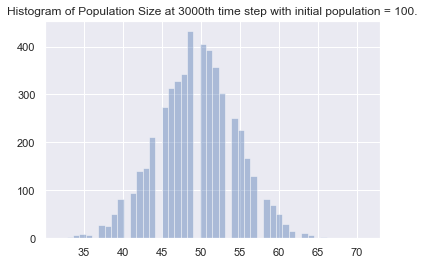

In [4]:
#--- Histogram of population time at t=3000
N_trial = 5000
P0 = 100
t = 3000

s = []
for i in range(N_trial):
    pop = popTrajectory(t, P0)
    s.append(pop[t-1])

pop_hist = sns.distplot(s, kde=False)
plt.title('Histogram of Population Size at {T}th time step with initial population = {P}.'.format(T=t,P=P0))
# plt.legend(loc="upper left")
plt.show()

fig = pop_hist.get_figure()
fig.savefig("1-2-Histogram.png") 

In [ ]:
# Find the extinction time
#--- Intial Parameters

r = 0.015
K = 8
t = 8000
P0 = 100  #Initial population

N = 2*K


# Function: Extinction time
@jit(nopython=True)
def extinctionTime(pop):
    extime = 0
    while pop > 0:
        extime += 1
        b, d = findProp(pop)
        pop += changePop(b, d)
    return extime


# print("Extinction when ", extinctionTime(P0))

start = time.time()

p0 = np.arange(0,16) # generate the initial population vector
lp0 = len(p0)

ntrial = 50 # number of simulation for each element of p0

mean_extime = np.zeros(lp0)
for i in range(lp0):
    aextime = np.zeros(ntrial)
    for j in range(ntrial):
        aextime[j] = extinctionTime(p0[i])
    
    mean_extime[i] = np.mean(aextime)

# print(aextime)
end = time.time()
print('Computational time is {t}.'.format(t=end-start))

pop_meanex = pd.DataFrame(mean_extime,p0)
plot_meanex = sns.lineplot(data=pop_meanex)

plot_meanex.set(xlabel='Population', ylabel='Mean time to extinction')
plt.show()

fig = plot_meanex.get_figure()
fig.savefig("2-ExtinctionTime.png") 